In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mplsoccer import Pitch, Sbopen







In [57]:
parser = Sbopen()

games = parser.match(competition_id=55, season_id=282)

games[(games['home_team_name'] == 'Poland') | (games['away_team_name'] == 'Poland')]

temp_game = games[games['match_id'] == 3938641]

home_team = temp_game['home_team_name'].values[0]
away_team = temp_game['away_team_name'].values[0]

events, related, freeze, tactics = parser.event(3938641)

pitch = Pitch(line_zorder=2)
df = events.loc[(events['type_name'] == 'Pass') & (events['play_pattern_name'] == 'Regular Play')].copy()

df = df[['team_name', 'x', 'y']]

df.rename(columns={'team_name': 'team'}, inplace=True)

team_a = df[df['team'] == home_team]
team_b = df[df['team'] == away_team]

In [58]:
team_b['x'] = 120-team_b['x']
team_b['y'] = 80-team_b['y']



/var/folders/mn/686s79xs0mv06qcjlx9yv1440000gn/T/ipykernel_21041/3926305167.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_b['x'] = 120-team_b['x']
/var/folders/mn/686s79xs0mv06qcjlx9yv1440000gn/T/ipykernel_21041/3926305167.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_b['y'] = 80-team_b['y']


In [17]:
team_a.dtypes

team     object
x       float64
y       float64
dtype: object

In [59]:
df = pd.concat([team_a, team_b])

# Define pitch dimensions (length and width)
pitch_length = 120
pitch_width = 80

# Divide pitch into 30 zones (e.g., 5 rows x 6 columns)
num_vertical_zones = 5
num_horizontal_zones = 6

# Calculate zone boundaries
x_bins = np.linspace(0, pitch_length, num_horizontal_zones + 1)
y_bins = np.linspace(0, pitch_width, num_vertical_zones + 1)

# Count passes in each zone for each team
df['x_bin'] = pd.cut(df['x'], bins=x_bins, labels=False)
df['y_bin'] = pd.cut(df['y'], bins=y_bins, labels=False)

pass_counts = df.groupby(['x_bin', 'y_bin', 'team']).size().unstack(fill_value=0)



In [49]:
df[df['x_bin'].isna()]

,team,x,y,x_bin,y_bin


In [60]:
pass_counts

team         Austria  Poland
x_bin y_bin                 
0     0            3       3
      1            1       3
      2            1       8
      3            6       5
      4            4       2
1     0            7       3
      1            8       5
      2           11       4
      3           11       7
      4           12       3
2     0            3      11
      1            7       3
      2           13       3
      3           11       3
      4           15       8
3     0           10       5
      1           16       5
      2           11       1
      3            7       5
      4           13       2
4     0            7       5
      1           12       2
      2           10       2
      3            6       0
      4            2       4
5     0            4       1
      1           11       0
      2            8       0
      3            1       0

In [27]:
pass_counts['x_bin'] = pass_counts['x_bin'].astype('int64')
pass_counts['y_bin'] = pass_counts['y_bin'].astype('int64')

KeyError: 'x_bin'

In [56]:
home_team


'Poland'

In [61]:
# Calculate the difference between Team A and Team B in each zone
pass_diff = pass_counts.get(home_team, 0) - pass_counts.get(away_team, 0)

pass_diff

x_bin  y_bin
0      0         0
       1         2
       2         7
       3        -1
       4        -2
1      0        -4
       1        -3
       2        -7
       3        -4
       4        -9
2      0         8
       1        -4
       2       -10
       3        -8
       4        -7
3      0        -5
       1       -11
       2       -10
       3        -2
       4       -11
4      0        -2
       1       -10
       2        -8
       3        -6
       4         2
5      0        -3
       1       -11
       2        -8
       3        -1
dtype: int64

In [22]:
pass_diff_matrix

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

In [80]:
# Create a 2D array of the differences with proper shape
pass_diff_matrix = np.zeros((num_vertical_zones, num_horizontal_zones))

for (x_bin, y_bin), value in pass_diff.items():
    pass_diff_matrix[y_bin, x_bin] = value
    



In [83]:
pass_diff_matrix

array([[  0.,  -4.,   8.,  -5.,  -2.,  -3.],
       [  2.,  -3.,  -4., -11., -10., -11.],
       [  7.,  -7., -10., -10.,  -8.,  -8.],
       [ -1.,  -4.,  -8.,  -2.,  -6.,  -1.],
       [ -2.,  -9.,  -7., -11.,   2.,   0.]])

In [94]:
from plotly_football_pitch import make_pitch_figure, PitchDimensions, add_heatmap


dimensions = PitchDimensions()
fig = make_pitch_figure(dimensions)

# define number of grid squares for heatmap data
width_grid = 12
length_grid = 15

data = pass_diff_matrix

fig = add_heatmap(fig, data, colorscale = 'oxy')
fig.update_yaxes(autorange="reversed")

fig.show()

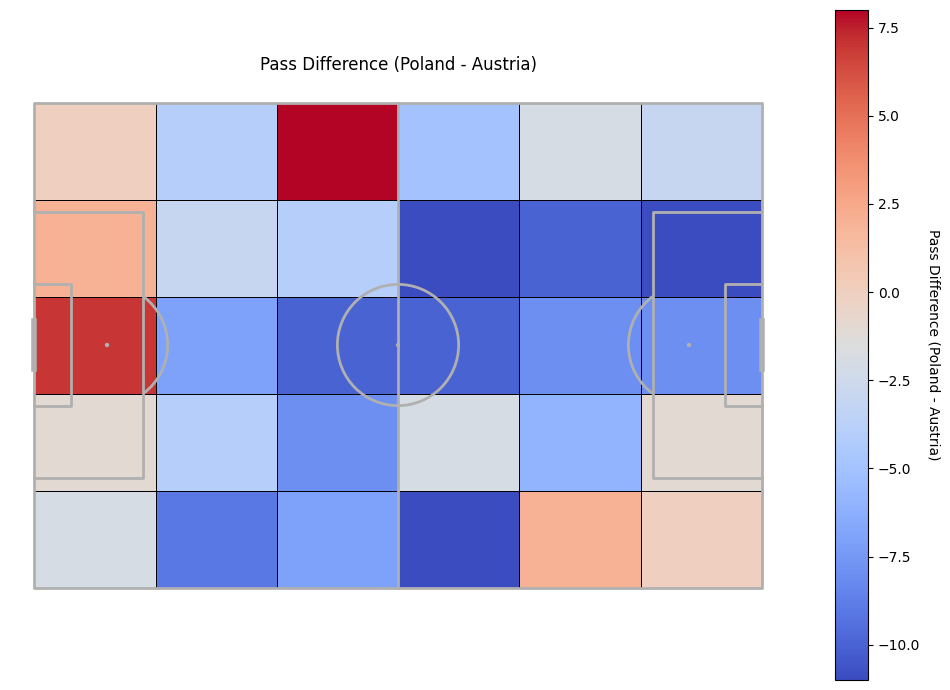

In [74]:
# Plot the difference using mplsoccer
pitch = Pitch(pitch_type='statsbomb', line_zorder=2)
fig, ax = pitch.draw(figsize=(10, 7))

# Prepare data for heatmap plotting
x_bin_centers = (x_bins[:-1] + x_bins[1:]) / 2
y_bin_centers = (y_bins[:-1] + y_bins[1:]) / 2

# Plot the heatmap
heatmap = ax.pcolormesh(x_bin_centers, y_bin_centers, pass_diff_matrix, cmap='coolwarm', edgecolors='k', linewidth=0.5)

# Add a color bar
cbar = fig.colorbar(heatmap, ax=ax)
cbar.set_label(f'Pass Difference ({home_team} - {away_team})', rotation=270, labelpad=15)

plt.title(f'Pass Difference ({home_team} - {away_team})')
plt.show()

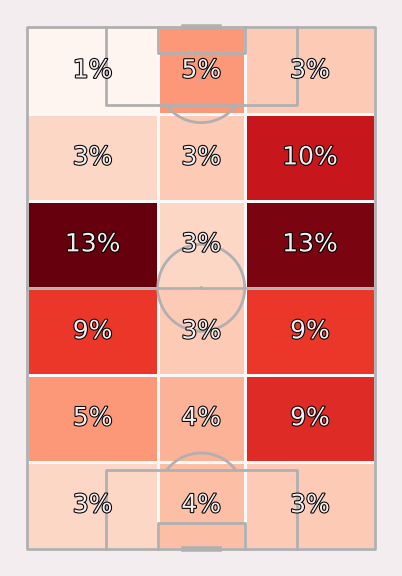

In [68]:
from mplsoccer import VerticalPitch
import matplotlib.patheffects as path_effects


path_eff = [path_effects.Stroke(linewidth=1.5, foreground='black'),
            path_effects.Normal()]

df_pressure = events.loc[(events['type_name'] == 'Pressure')].copy()

team_a = df_pressure[df_pressure['team_name'] == 'Austria']

pitch = VerticalPitch(pitch_type='statsbomb', line_zorder=2, pitch_color='#f4edf0')
fig, ax = pitch.draw(figsize=(4.125, 6))
fig.set_facecolor('#f4edf0')
bin_x = np.linspace(pitch.dim.left, pitch.dim.right, num=7)
bin_y = np.sort(np.array([pitch.dim.bottom, pitch.dim.six_yard_bottom,
                          pitch.dim.six_yard_top, pitch.dim.top]))
bin_statistic = pitch.bin_statistic(team_a.x, team_a.y, statistic='count',
                                    bins=(bin_x, bin_y), normalize=True)
pitch.heatmap(bin_statistic, ax=ax, cmap='Reds', edgecolor='#f9f9f9')
labels2 = pitch.label_heatmap(bin_statistic, color='#f4edf0', fontsize=18,
                              ax=ax, ha='center', va='center',
                              str_format='{:.0%}', path_effects=path_eff)

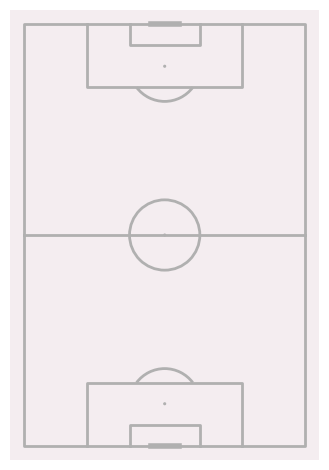

In [70]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from mplsoccer import VerticalPitch

# Assuming 'events' DataFrame is already loaded
df_pressure = events.loc[events['type_name'] == 'Pressure'].copy()
team_a = df_pressure[df_pressure['team_name'] == 'Austria']

pitch = VerticalPitch(pitch_type='statsbomb', line_zorder=2, pitch_color='#f4edf0')

# Create bins
bin_x = np.linspace(pitch.dim.left, pitch.dim.right, num=7)
bin_y = np.sort(np.array([pitch.dim.bottom, pitch.dim.six_yard_bottom,
                          pitch.dim.six_yard_top, pitch.dim.top]))

# Calculate bin statistics
bin_statistic = pitch.bin_statistic(team_a.x, team_a.y, statistic='count',
                                    bins=(bin_x, bin_y), normalize=True)

# Create heatmap data
heatmap_data = go.Heatmap(
    z=bin_statistic['statistic'],
    x=bin_statistic['cx'],
    y=bin_statistic['cy'],
    colorscale='Reds',
    showscale=False,
    hovertemplate='X: %{x:.1f}<br>Y: %{y:.1f}<br>Pressure: %{z:.1%}<extra></extra>'
)

# Create the pitch lines
pitch_lines = pitch.draw(ax=None)
pitch_traces = []
for element in pitch_lines:
    if element.get_label() == '<PolyCollection>' or element.get_label() == '<LineCollection>':
        for path in element.get_paths():
            v = path.vertices
            pitch_traces.append(go.Scatter(x=v[:, 0], y=v[:, 1], mode='lines', line=dict(color='black', width=1),
                                           hoverinfo='skip'))

# Create the figure
fig = go.Figure(data=[heatmap_data] + pitch_traces)

# Update layout
fig.update_layout(
    title='Pressure Heatmap',
    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    plot_bgcolor='#f4edf0',
    width=400,
    height=600,
    autosize=False,
    showlegend=False
)

# Show the plot
fig.show()

In [42]:
import duckdb

from statsbombpy import sb

events = sb.events(match_id = 3938637)

games = sb.matches(competition_id=55, season_id=282)

events.columns


Index(['50_50', 'ball_receipt_outcome', 'ball_recovery_recovery_failure',
       'block_deflection', 'carry_end_location', 'clearance_aerial_won',
       'clearance_body_part', 'clearance_head', 'clearance_left_foot',
       'clearance_right_foot', 'counterpress', 'dribble_nutmeg',
       'dribble_outcome', 'dribble_overrun', 'duel_outcome', 'duel_type',
       'duration', 'foul_committed_card', 'foul_won_defensive',
       'goalkeeper_body_part', 'goalkeeper_end_location', 'goalkeeper_outcome',
       'goalkeeper_position', 'goalkeeper_technique', 'goalkeeper_type', 'id',
       'index', 'interception_outcome', 'location', 'match_id', 'minute',
       'off_camera', 'out', 'pass_aerial_won', 'pass_angle',
       'pass_assisted_shot_id', 'pass_body_part', 'pass_cross',
       'pass_cut_back', 'pass_deflected', 'pass_end_location',
       'pass_goal_assist', 'pass_height', 'pass_inswinging', 'pass_length',
       'pass_no_touch', 'pass_outcome', 'pass_outswinging', 'pass_recipient',
    

In [4]:
shots = duckdb.sql("select a.possession, a.team, a.shot_statsbomb_xg, b.pass_type from (select possession, team, shot_statsbomb_xg, shot_outcome, shot_key_pass_id from events where type = 'Shot') a left join (select id, ifnull(pass_type, 'Open Play') as pass_type from events where type = 'Pass') b on a.shot_key_pass_id = b.id")
duckdb.sql("select * from shots")

┌────────────┬─────────────┬───────────────────┬───────────┐
│ possession │    team     │ shot_statsbomb_xg │ pass_type │
│   int64    │   varchar   │      double       │  varchar  │
├────────────┼─────────────┼───────────────────┼───────────┤
│          5 │ Netherlands │       0.010196376 │ Open Play │
│         11 │ Netherlands │        0.11391678 │ Open Play │
│         16 │ Netherlands │       0.114312105 │ Open Play │
│         17 │ Poland      │        0.04367851 │ Open Play │
│         22 │ Netherlands │       0.015395193 │ Open Play │
│         25 │ Poland      │        0.08721661 │ Corner    │
│         28 │ Netherlands │       0.033487294 │ Corner    │
│         40 │ Netherlands │       0.110036224 │ Open Play │
│         41 │ Netherlands │       0.010005396 │ Open Play │
│         43 │ Netherlands │       0.048307355 │ Recovery  │
│          · │      ·      │             ·     │   ·       │
│          · │      ·      │             ·     │   ·       │
│          · │      ·   

In [84]:
duckdb.default_connection.execute("SET GLOBAL pandas_analyze_sample=100000")


duckdb.sql("select team, pass_type from events where pass_type = 'Free Kick'")

┌─────────────┬───────────┐
│    team     │ pass_type │
│   varchar   │  varchar  │
├─────────────┼───────────┤
│ Netherlands │ Free Kick │
│ Netherlands │ Free Kick │
│ Poland      │ Free Kick │
│ Poland      │ Free Kick │
│ Poland      │ Free Kick │
│ Netherlands │ Free Kick │
│ Netherlands │ Free Kick │
│ Netherlands │ Free Kick │
│ Poland      │ Free Kick │
│ Netherlands │ Free Kick │
│ Poland      │ Free Kick │
│ Poland      │ Free Kick │
│ Poland      │ Free Kick │
│ Netherlands │ Free Kick │
│ Netherlands │ Free Kick │
│ Poland      │ Free Kick │
│ Netherlands │ Free Kick │
│ Netherlands │ Free Kick │
│ Netherlands │ Free Kick │
│ Netherlands │ Free Kick │
├─────────────┴───────────┤
│ 20 rows       2 columns │
└─────────────────────────┘

In [6]:
duckdb.sql("select possession, team, shot_statsbomb_xg, shot_outcome, shot_key_pass_id from events where type = 'Shot' and shot_outcome = 'Goal' order by possession")


┌────────────┬─────────────┬───────────────────┬──────────────┬──────────────────────────────────────┐
│ possession │    team     │ shot_statsbomb_xg │ shot_outcome │           shot_key_pass_id           │
│   int64    │   varchar   │      double       │   varchar    │               varchar                │
├────────────┼─────────────┼───────────────────┼──────────────┼──────────────────────────────────────┤
│         25 │ Poland      │        0.08721661 │ Goal         │ 9a034727-be69-45db-9057-da1767584734 │
│         43 │ Netherlands │       0.048307355 │ Goal         │ 71680f21-df9d-4cea-bddb-af137c77979d │
│        129 │ Netherlands │        0.09464203 │ Goal         │ NULL                                 │
└────────────┴─────────────┴───────────────────┴──────────────┴──────────────────────────────────────┘

In [51]:
shots = duckdb.sql("select a.possession, a.team, a.shot_statsbomb_xg, b.pass_type from (select possession, team, shot_statsbomb_xg, shot_outcome, shot_key_pass_id from events where type = 'Shot') a left join (select id, ifnull(pass_type, 'Open Play') as pass_type from events where type = 'Pass') b on a.shot_key_pass_id = b.id")


xg_table = duckdb.sql("select team, sum(sum_xg) as overall_xg, sum(case when pass_type = 'Set Piece' then sum_xg end) as set_piece_xg from (select team, case when pass_type = 'Corner' or pass_type = 'Free Kick' then 'Set Piece' else 'Open Play' end as pass_type, sum(shot_xg) as sum_xg from (select possession, team, max(shot_statsbomb_xg) as shot_xg, pass_type from shots group by possession, team, pass_type) group by 1,2) group by 1")

In [57]:
events[['x', 'y']] = events['location'].apply(pd.Series)
events[['end_x', 'end_y']] = events['pass_end_location'].apply(pd.Series)

In [80]:
passes = duckdb.sql("select player, team, x,y, end_x, end_y, ifnull(pass_outcome, 'Complete') as pass_outcome, ifnull(pass_type, 'Regular Play') as pass_type from events where type = 'Pass'")

passes

┌─────────────────────┬─────────────┬────────┬────────┬────────┬────────┬──────────────┬──────────────┐
│       player        │    team     │   x    │   y    │ end_x  │ end_y  │ pass_outcome │  pass_type   │
│       varchar       │   varchar   │ double │ double │ double │ double │   varchar    │   varchar    │
├─────────────────────┼─────────────┼────────┼────────┼────────┼────────┼──────────────┼──────────────┤
│ Piotr Zieliński     │ Poland      │   60.0 │   40.0 │   56.3 │   43.0 │ Complete     │ Kick Off     │
│ Sebastian Szymański │ Poland      │   55.7 │   42.8 │   68.6 │    4.4 │ Complete     │ Regular Play │
│ Nicola Zalewski     │ Poland      │   68.1 │    4.2 │  107.3 │   22.8 │ Incomplete   │ Regular Play │
│ Bart Verbruggen     │ Netherlands │   12.0 │   44.9 │   15.0 │   32.4 │ Complete     │ Regular Play │
│ Virgil van Dijk     │ Netherlands │   15.0 │   32.4 │    9.7 │   45.7 │ Complete     │ Regular Play │
│ Bart Verbruggen     │ Netherlands │   16.5 │   42.4 │   17.5 │

In [82]:
duckdb.sql("""select player, team, x, y, end_x, end_y from passes
                    where end_x > 100 and end_y > 20 and end_y < 60 and pass_type = 'Regular Play' and pass_outcome = 'Complete'""")

ParserException: Parser Error: syntax error at or near "pass_type"
LINE 2: ...d_x, end_y from passes
                    where end_x > 100 and end_y > 20 an...
                                                  ^

In [65]:
pressures = duckdb.sql("""select team, count(*) as pressures_in_opp_half from (select team, possession, timestamp, x, y from events where type = 'Pressure' and x > 60) group by 1""")

pressures

┌─────────────┬───────────────────────┐
│    team     │ pressures_in_opp_half │
│   varchar   │         int64         │
├─────────────┼───────────────────────┤
│ Poland      │                    34 │
│ Netherlands │                    72 │
└─────────────┴───────────────────────┘

In [72]:
table = duckdb.sql("select xg_table.team, xg_table.overall_xg, xg_table.set_piece_xg, penalty_pass.passes_to_penalty_area, pressures.pressures_in_opp_half from xg_table join penalty_pass on xg_table.team = penalty_pass.team join pressures on xg_table.team = pressures.team").df()

table.transpose()

,0,1
team,Poland,Netherlands
overall_xg,0.872942,1.302073
set_piece_xg,0.382089,0.102258
passes_to_penalty_area,3,10
pressures_in_opp_half,34,72


In [20]:
duckdb.sql("select count(*) from shots")

┌──────────────┐
│ count_star() │
│    int64     │
├──────────────┤
│           33 │
└──────────────┘

In [9]:
shots_type = duckdb.sql("""select distinct events.possession, first_value(play_pattern) over (partition by events.possession, events.team order by timestamp) as play_pattern, shots.shot_statsbomb_xg, events.team, first_value(type) over (partition by events.possession, events.team order by timestamp) as type, first_value(location) over (partition by events.possession, events.team order by timestamp) as location,
                        first_value(events.pass_type) over (partition by events.possession, events.team order by timestamp) as pass_type, shots.shot_outcome
                        from events 
                        join shots on events.possession = shots.possession and events.team = shots.team
                        order by 1""")

BinderException: Binder Error: Values list "shots" does not have a column named "shot_outcome"

In [7]:
shots_type

NameError: name 'shots_type' is not defined

In [45]:
events = sb.events(match_id = 3938637)


events[['x', 'y']] = events['location'].apply(pd.Series)
events[['end_x', 'end_y']] = events['pass_end_location'].apply(pd.Series)


passes = events[events['type'] == 'Pass']

passes['pass_type'] = passes['pass_type'].fillna('Regular Play')

passes['pass_type'].unique()


/var/folders/mn/686s79xs0mv06qcjlx9yv1440000gn/T/ipykernel_43182/171775891.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  passes['pass_type'] = passes['pass_type'].fillna('Regular Play')


array(['Kick Off', 'Regular Play', 'Recovery', 'Throw-in', 'Corner',
       'Free Kick', 'Goal Kick', 'Interception'], dtype=object)

In [46]:
duckdb.sql("select player, team, x, y, end_x, end_y,  ifnull(pass_outcome, 'Complete') as pass_outcome, pass_type from passes")

┌─────────────────────┬─────────────┬────────┬────────┬────────┬────────┬──────────────┬──────────────┐
│       player        │    team     │   x    │   y    │ end_x  │ end_y  │ pass_outcome │  pass_type   │
│       varchar       │   varchar   │ double │ double │ double │ double │   varchar    │   varchar    │
├─────────────────────┼─────────────┼────────┼────────┼────────┼────────┼──────────────┼──────────────┤
│ Piotr Zieliński     │ Poland      │   60.0 │   40.0 │   56.3 │   43.0 │ Complete     │ Kick Off     │
│ Sebastian Szymański │ Poland      │   55.7 │   42.8 │   68.6 │    4.4 │ Complete     │ Regular Play │
│ Nicola Zalewski     │ Poland      │   68.1 │    4.2 │  107.3 │   22.8 │ Incomplete   │ Regular Play │
│ Bart Verbruggen     │ Netherlands │   12.0 │   44.9 │   15.0 │   32.4 │ Complete     │ Regular Play │
│ Virgil van Dijk     │ Netherlands │   15.0 │   32.4 │    9.7 │   45.7 │ Complete     │ Regular Play │
│ Bart Verbruggen     │ Netherlands │   16.5 │   42.4 │   17.5 │

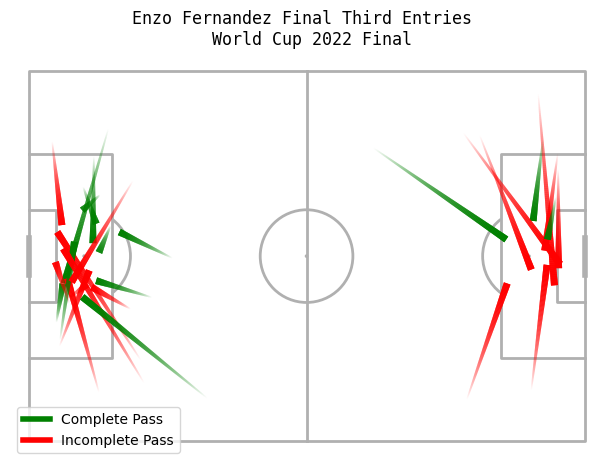

In [47]:
passes = duckdb.sql("""select player, team, x, y, end_x, end_y,  ifnull(pass_outcome, 'Complete') as pass_outcome, ifnull(pass_type, 'Regular Play') as pass_type from passes
                    where end_x > 100 and end_y > 30 and end_y < 50 and end_x < 115 and pass_type = 'Regular Play'""").df()

fig, ax = pitch.draw()

for x in passes.to_dict(orient = 'records'):
    if x['team'] == 'Poland':
        if x['pass_outcome'] =='Complete':
            pitch.lines(x['x'], x['y'], x['end_x'], x['end_y'], lw = 5,
                        transparent = True, comet = True, ax = ax, color = 'g')
        else:
            pitch.lines(x['x'], x['y'], x['end_x'], x['end_y'], lw=5,
                        transparent=True, comet=True, ax=ax, color='r')
    else:
        x['x'] = 120 - x['x']
        x['y'] = 80 - x['y']
        x['end_x'] = 120 - x['end_x']
        x['end_y'] = 80 - x['end_y']
        if x['pass_outcome'] =='Complete':
            pitch.lines(x['x'], x['y'], x['end_x'], x['end_y'], lw = 5,
                        transparent = True, comet = True, ax = ax, color = 'g')
        else:
            pitch.lines(x['x'], x['y'], x['end_x'], x['end_y'], lw=5,
                        transparent=True, comet=True, ax=ax, color='r')
        
ax.set_title('Enzo Fernandez Final Third Entries \n World Cup 2022 Final', fontsize = 12, fontfamily = 'monospace')

from matplotlib.lines import Line2D

legend_elements = [
    Line2D([0], [0], color = 'g', lw = 4, label = 'Complete Pass'),
    Line2D([0], [0], color='r', lw=4, label='Incomplete Pass'),

]

ax.legend(handles = legend_elements, loc = 'lower left')